In [1]:
trgMu_pt_region = 'all'

# Import

In [2]:
import sys, os
from glob import glob
sys.path.append('../lib')
import itertools

In [3]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.interpolate import interp1d
from array import array
from multiprocessing import Pool

import uproot as ur
import ROOT as rt
rt.gErrorIgnoreLevel = rt.kError
rt.RooMsgService.instance().setGlobalKillBelow(rt.RooFit.ERROR)
import root_numpy as rtnp

from analysis_utilities import drawOnCMSCanvas, extarct, extarct_multiple, createSel
from histo_utilities import create_TH1D, create_TH2D, std_color_list, SetMaxToMaxHist
from cebefo_style import Set_2D_colz_graphics
from progressBar import ProgressBar

import CMS_lumi, tdrstyle
tdrstyle.setTDRStyle()
CMS_lumi.writeExtraText = 1

CMS_lumi.extraText = "      Simulation Preliminary"

donotdelete = []

Welcome to JupyROOT 6.12/07


In [4]:
colors = {'data':rt.kBlack,
          'mu': rt.kAzure+1, 
          'tau': rt.kRed-4, 
          'Hc':rt.kGreen+1, 
          'Dstst': rt.kMagenta-7
         }

In [5]:
label_dic = {'data' : 'Data',
                 'mu' : 'B#rightarrow D*#mu#nu',
                 'tau' : 'B#rightarrow D*#tau#nu',
                 'Hc' : 'B#rightarrow D*H_{c}',
                 'Dstst': 'B#rightarrow D**#mu#nu'
                }

# Define binning

In [6]:
binning = {
    'q2'      : array('d', [-2, 1.5, 4, 6, 12]),
    'M2_miss' : [
        array('d', [-2.5] + list(np.arange(-1.8, 0.4, 0.5)) + [6] ),
        array('d', [-2.5] + list(np.arange(-1.8, 1.6, 0.5)) + [6] ),
        array('d', [-2.5] + list(np.arange(-1.8, 3.0, 0.5)) + [6] ),
        array('d', [-2.5] + list(np.arange(-1.8, 5.0, 0.5)) + [6] ),
    ],
    'Est_mu'  : [
        array('d', [0.5] + list(np.arange(0.8, 2.3, 0.1)) + [2.5] ),
        array('d', [0.5] + list(np.arange(0.8, 2.5, 0.1)) + [2.5] ),
        [20, 0.50, 2.500],
        [20, 0.50, 2.500],
    ]
}

# Create histograms file

In [7]:
file_loc = {
'mu'   : '../data/cmsMC_private/BPH_Tag-B0_MuNuDmst-pD0bar-kp_13TeV-pythia8_Hardbbbar_PTFilter5_0p0-evtgen_ISGW2_PU20_10-2-3/ntuples_B2DstMu/out_CAND_*.root',
'tau'  : '../data/cmsMC_private/BPH_Tag-B0_TauNuDmst-pD0bar-kp-t2mnn_pythia8_Hardbbbar_PTFilter5_0p0-evtgen_ISGW2_PU20_10-2-3/ntuples_B2DstMu/out_CAND_*.root',
# 'Hc'   : '../data/cmsMC_private/BPH_Tag-B0_DmstHc-pD0bar-kp-Hc2mu_13TeV-pythia8_Hardbbbar_PTFilter5_0p0-evtgen_PU20_10-2-3/ntuples_B2DstMu/out_CAND_*.root',
# 'Dstst'   : '../data/cmsMC_private/BPH_Tag-Bp_MuNuDstst_DmstPi_13TeV-pythia8_Hardbbbar_PTFilter5_0p0-evtgen_ISGW2_PU20_10-2-3/ntuples_B2DstMu/out_CAND_*.root'
}

In [8]:
def trigger_selection(ev):        
    if trgMu_pt_region == 'none':
        aux = True
    elif trgMu_pt_region == 'high':
        aux = ev.trgMu_HLT_Mu12_IP6 == 1
        aux &= ev.trgMu_pt > 12.1
    elif trgMu_pt_region == 'mid':
        aux = ev.trgMu_HLT_Mu12_IP6 == 0
        aux &= ev.trgMu_HLT_Mu9_IP6 == 1
        aux &= ev.trgMu_pt > 9.1
        aux &= ev.trgMu_pt < 11.9
    elif trgMu_pt_region == 'all':
        aux = ev.trgMu_HLT_Mu12_IP6 == 1
        aux = aux or ev.trgMu_HLT_Mu9_IP6 == 1
    else:
        raise

    aux &= abs(ev.trgMu_eta) < 2.4
    aux &= ev.trgMu_sigdxy > 7
    return aux

In [9]:
def candidate_selection(j, ev):
    aux = ev.pval_piK[j] > 0.1
    aux &= ev.K_pt[j] > 0.8
    aux &= abs(ev.K_eta[j]) < 2.5
    aux &= ev.pi_pt[j] > 0.8
    aux &= abs(ev.pi_eta[j]) < 2.5
    aux &= abs(ev.mass_piK[j] - 1.86) < 0.04
    if not aux: 
        return False

    aux = ev.pis_pt[j] > 0.5
    aux &= ev.pval_D0pis[j] > 0.1
    aux &= abs(ev.mass_D0pis[j] - 2.01) < 0.03
    aux &= ev.sigdxy_pis_PV[j] > 2
    aux &= ev.mass_D0pis[j] < ev.mass_piK[j] + 0.16
    aux &= ev.pval_D0pismu[j] > 0.1
    aux &= ev.cos_D0pismu_PV[j] > 0.99
    aux &= ev.q2_D0pismu[j] > binning['q2'][0]
    aux &= ev.q2_D0pismu[j] < binning['q2'][-1]
    aux &= ev.mass_D0pismu[j] < 7.
    if not aux: 
        return False
    
    if not ev.nTksAdd[j] == 0:
        idx_st = int(np.sum(ev.nTksAdd[:j]))
        # DEBUG controlla questa linea la prossima volta che fai le ntuple
        idx_stop = min(ev.tksAdd_massVis.size(), int(idx_st + ev.nTksAdd[j]))
        for jj in range(idx_st, idx_stop):
            if ev.tksAdd_massVis[jj] < 5.28:
                return False
    
    return True

In [11]:
dSet = {}
recreate = True
for n, filepath in file_loc.iteritems():
    print n
    fskimmed_name = 'tmp/' + n + '_MC.root'
    if os.path.isfile(fskimmed_name) and not recreate:
        print n+':', 'Loading'
        dSet[n] = rtnp.root2array(fskimmed_name)
    else:
        tree = rt.TChain('outA/Tevts')
        for fn in glob(filepath):
            tree.Add(fn)
        
        pb = ProgressBar(maxEntry=float(tree.GetEntries()))
        N_accepted_cand = []
        output = []
        for i_ev, ev in enumerate(tree):
            pb.show(i_ev)
            N_acc = 0
            
            if not trigger_selection(ev): 
                continue
                
            for j in range(ev.pval_piK.size()):
                if not candidate_selection(j, ev):
                    continue
                    
                N_acc += 1
                aux = (ev.MC_q2, ev.MC_Est_mu, ev.MC_M2_miss, ev.mass_D0pismu[j])
                aux += (ev.trgMu_pt, ev.trgMu_sigdxy)
                if not n == 'data':
                    aux += (ev.MC_B_pt, ev.MC_B_eta)
                if n == 'tau' or n == 'mu':
                    aux += (
                           ev.wh_CLNCentral,
                           ev.wh_CLNR0Down,
                           ev.wh_CLNR0Up,
                           ev.wh_CLNR1Down,
                           ev.wh_CLNR1Up,
                           ev.wh_CLNR2Down,
                           ev.wh_CLNR2Up,
                           ev.wh_CLNRhoSqDown,
                           ev.wh_CLNRhoSqUp,
                    )
                
                output.append(aux)
            
            if N_acc > 0:
                N_accepted_cand.append(N_acc)
        
        print 'Loop done'
        dic = {i:N_accepted_cand.count(i) for i in range(1, np.max(N_accepted_cand)+1)}
        print dic

        leafs_names = ['q2', 'Est_mu', 'M2_miss', 'M_vis', 'trgMu_pt', 'trgMu_sigdxy']
        if not n == 'data':
            leafs_names += ['MC_B_pt', 'MC_B_eta']
        if n == 'tau' or n == 'mu':
            leafs_names += ['wh_CLNCentral', 'wh_CLNR0Down', 'wh_CLNR0Up', 'wh_CLNR1Down', 'wh_CLNR1Up', 'wh_CLNR2Down', 'wh_CLNR2Up', 'wh_CLNRhoSqDown', 'wh_CLNRhoSqUp']

        dtypes = []
        for nl in leafs_names:
            dtypes.append((nl, np.float32))
            
        dSet[n] = np.array(output, dtype=dtypes)
        if not os.path.isdir(os.path.dirname(fskimmed_name)):
            os.makedirs(os.path.dirname(fskimmed_name))
        rtnp.array2root(dSet[n], fskimmed_name, treename='Tevts', mode='RECREATE')
        
    aux = dSet[n].dtype.fields.keys()[0]
    print 'Events:', dSet[n][aux].shape[0]
    print ''

mu
[####################]  100% - Tot. time: 330.8 s
Loop done
{1: 219541, 2: 8}
Events: 219557

tau
[####################]  100% - Tot. time: 50.8 s
Loop done
{1: 20379}
Events: 20379



In [12]:
np.sum(np.logical_and(dSet['mu']['trgMu_pt']<11.9, dSet['mu']['trgMu_pt']<9.1))

3604

In [13]:
class PTCalibration:
    def __init__(self, calibration_dic=None, calibration_file=None):
        if not calibration_dic is None:
            self.calibration_dic = calibration_dic
            d = calibration_dic
        elif not calibration_file is None:
            d = {}
            lines = open(calibration_file, 'r').readlines()
            keys = lines[0][1:-1].split('\t')
            for k in keys: d[k] = []
            
            for l in lines[1:]:
                l = l[:-1]
                v = l.split('\t')
                for i in range(len(v)):
                    d[keys[i]].append(float(v[i]))
            
            self.calibration_dic = d
        else:
            raise
        
        self.f = {}
        self.f['C'] = interp1d(d['pt'], d['w'], 
                               fill_value=(d['w'][0], d['w'][-1]),
                               bounds_error=False,
                               kind='cubic'
                                                )
        self.f['Up'] = interp1d(d['pt'], d['wUp'], 
                               fill_value=(d['wUp'][0], d['wUp'][-1]),
                               bounds_error=False,
                               kind='cubic'
                                                )
        self.f['Down'] = interp1d(d['pt'], d['wDown'], 
                               fill_value=(d['wDown'][0], d['wDown'][-1]),
                               bounds_error=False,
                               kind='cubic'
                                                )
fname = '../data/calibration/B02JPsiKst_Mu12_pt.txt'
if trgMu_pt_region == 'mid':
    fname = '../data/calibration/B02JPsiKst_Mu9_pt.txt'
cal_pT = PTCalibration(calibration_file=fname)

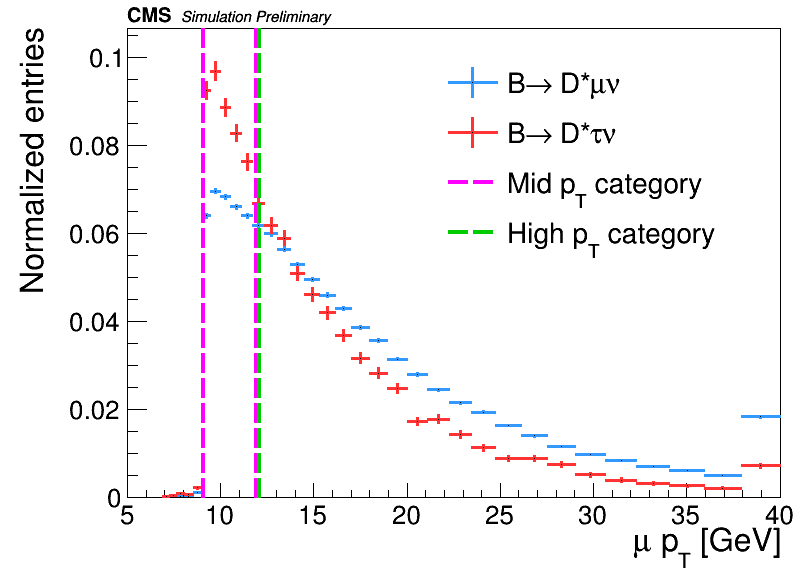

In [21]:
h_l = []
leg = rt.TLegend(0.55, 0.55, 0.9, 0.9)
leg.SetTextFont(42)
leg.SetTextAlign(12)
leg.SetLineWidth(0)
leg.SetBorderSize(0)
                
for n in file_loc.keys():
    d = dSet[n]
    if n in ['Dstst', 'data']:
        w = None
    else:
        w = cal_pT.f['C'](d['MC_B_pt'])
    
    h = create_TH1D(d['trgMu_pt'], name='h_trgMupT_'+n, title=n, 
                    axis_title=['#mu p_{T} [GeV]', 'Normalized entries'],
                    binning=np.logspace(np.log10(5), np.log10(40), 40), 
                    opt='underflow,overflow',
                    weights=w,
                    scale_histo=1./np.sum(w) if not w is None else 1./float(d['trgMu_pt'].shape[0]),
                   )
    h.SetLineColor(colors[n])
    h.SetLineWidth(3)
    leg.AddEntry(h, label_dic[n], 'lep')
    h_l.append(h)
    
m = SetMaxToMaxHist(h_l)
c = drawOnCMSCanvas(CMS_lumi, h_l, 'same')
leg.Draw()
l = rt.TLine()
l.SetLineColor(6)
l.SetLineStyle(9)
l.SetLineWidth(4)

l.DrawLine(11.9, 0, 11.9, m)
l.DrawLine(9.1, 0, 9.1, m)
leg.AddEntry(l, 'Mid p_{T} category', 'l')

l2 = l.Clone()
l2.SetLineColor(rt.kGreen+1)
l2.DrawLine(12.1, 0, 12.1, m)
leg.AddEntry(l2, 'High p_{T} category', 'l')

c.Draw()

In [ ]:
h_l = []
for n in ['mu', 'tau', 'Hc', 'Dstst']:
    d = dSet[n]
    if n in ['Dstst', 'data']:
        w = None
    else:
        w = cal_pT.f['C'](d['MC_B_pt'])
    
    h = create_TH1D(d['trgMu_sigdxy'], name='h_trgMuIP_'+n, title=n, 
                    axis_title=['Trigger #mu IP', 'Normalized entries'],
                    binning=np.logspace(0, np.log10(100), 50), 
                    opt='underflow,overflow',
                    weights=w,
                    scale_histo=1./np.sum(w) if not w is None else 1./float(d['trgMu_pt'].shape[0]),
                   )
    h.SetLineColor(colors[n])
    h_l.append(h)
    
m = SetMaxToMaxHist(h_l)
c = drawOnCMSCanvas(CMS_lumi, h_l, 'same')

l = rt.TLine()
l.SetLineColor(6)
l.SetLineStyle(9)
l.SetLineWidth(2)

l.DrawLine(6, 0, 6, m)
l.DrawLine(5, 0, 5, m)
c.Draw()
c.SetLogx()
c.SetLogy()

In [ ]:
h_l = []
for n in ['mu', 'tau', 'Hc', 'Dstst']:
    d = dSet[n]
    if n=='Dstst':
        w = None
    else:
        w = cal_pT.f['C'](d['MC_B_pt'])
    
    h = create_TH1D(d['q2'], name='h_q2_'+n, title=n, 
                    binning=[30, -5, 12], 
                    axis_title=['q^{2}', 'Normalized entries'],
                    opt='underflow,overflow',
                    weights=w,
                    scale_histo=1./np.sum(w) if not w is None else 1./float(d['MC_B_pt'].shape[0]),
                   )
    h.SetLineColor(colors[n])
    h_l.append(h)
    
m = SetMaxToMaxHist(h_l)
c = drawOnCMSCanvas(CMS_lumi, h_l, 'same')

l = rt.TLine()
l.SetLineColor(6)
l.SetLineStyle(9)
l.SetLineWidth(2)

l.DrawLine(2.1, 0, 2.1, m)
l.DrawLine(4, 0, 4, m)
l.DrawLine(6.5, 0, 6.5, m)
c.Draw()

In [ ]:
h_l = []
for n in ['mu', 'tau', 'Hc', 'Dstst']:
    d = dSet[n]
    if n=='Dstst':
        w = None
    else:
        w = cal_pT.f['C'](d['MC_B_pt'])
    
    h = create_TH1D(d['q2'], name='h_q2_'+n, title=n, 
                                    binning=binning['q2'], 
                                    opt='underflow,overflow',
                                    weights=w,
                                    scale_histo=1./np.sum(w) if not w is None else 1./float(d['MC_B_pt'].shape[0]),
                                   )
    h.SetLineColor(colors[n])
    h_l.append(h)
    
m = SetMaxToMaxHist(h_l)
h_l[0].GetYaxis().SetRangeUser(0, m)
c = drawOnCMSCanvas(CMS_lumi, h_l, 'same')
c.Draw()

In [ ]:
h_l = []
for n in ['mu', 'tau', 'Hc', 'Dstst']:
    d = dSet[n]
    if n in ['data','Dstst']:
        w = None
    else:
        w = cal_pT.f['C'](d['MC_B_pt'])
        
    if n in ['mu', 'tau']:
        w *= d['wh_CLNCentral']
    
    h = create_TH1D(d['M_vis'], name='h_q2_'+n, title=n, 
                                    binning=[30, 2, 7], 
                                    opt='underflow,overflow',
                                    weights=w,
                                    scale_histo=1./np.sum(w) if not w is None else 1./float(d['q2'].shape[0]),
                                   )
    h.SetLineColor(colors[n])
    h_l.append(h)
    
m = SetMaxToMaxHist(h_l)
h_l[0].GetXaxis().SetTitle('M_{vis} [GeV]')
c = drawOnCMSCanvas(CMS_lumi, h_l, 'same')

l = rt.TLine()
l.SetLineColor(6)
l.SetLineStyle(9)
l.SetLineWidth(2)

mass_B0 = 5.27961
mass_Dst = 2.01027
l.DrawLine(mass_B0, 0, mass_B0, m)
l.DrawLine(mass_Dst, 0, mass_Dst, m)
c.Draw()

In [ ]:
histo = {}
for i_q2 in range(len(binning['q2'])-1):
    q2_l = binning['q2'][i_q2]
    q2_h = binning['q2'][i_q2 + 1]

    for var in ['M2_miss', 'Est_mu']:
        cat_name = var+'_q2-'+str(i_q2)
        histo[cat_name] = {}
        for k,d in dSet.iteritems():          
            q2_bin = np.logical_and(d['q2'] > q2_l, d['q2'] < q2_h)
            if k == 'data':
                
                sel = np.logical_and(d['q2'] > binning['q2'][0], d['q2'] < binning['q2'][-1])
                data_norm = np.sum(sel)

                histo[cat_name][k] = create_TH1D(d[var][q2_bin], 
                                                 name=k, title=k,
                                                 binning=binning[var][i_q2],
                                                 opt='underflow,overflow',
                                                 scale_histo=1./data_norm
                                                )
            elif k in ['mu', 'tau', 'Hc']:
                for k_wpT in ['C', 'Up', 'Down']:
                    h_name = k
                    if k_wpT != 'C':
                        h_name += '__B0pT' + k_wpT
                        
                    w = cal_pT.f[k_wpT](d['MC_B_pt'][q2_bin])
                    
                    sel_q2 = np.logical_and(d['q2'] > binning['q2'][0], d['q2'] < binning['q2'][-1])
                    norm = np.sum(cal_pT.f[k_wpT](d['MC_B_pt'][sel_q2]))
                    h = create_TH1D(d[var][q2_bin], name=h_name, title=h_name, 
                                    binning=binning[var][i_q2], 
                                    opt='underflow,overflow',
                                    weights=w,
                                    scale_histo=1./norm,
                                   )
                    histo[cat_name][h_name] = h
            elif k in ['Dstst']:
                h_name = k
                sel_q2 = np.logical_and(d['q2'] > binning['q2'][0], d['q2'] < binning['q2'][-1])
                norm = float(np.sum(sel_q2))
                h = create_TH1D(d[var][q2_bin], name=h_name, title=h_name, 
                                binning=binning[var][i_q2], 
                                opt='underflow,overflow',
                                scale_histo=1./norm,
                               )
                histo[cat_name][h_name] = h

In [ ]:
def plot_gridVarQ2(CMS_lumi, binning, histo, scale_dic, min_y=1e-4):
    canvas = rt.TCanvas('c_out', 'c_out', 50, 50, 2*600, 400*len(binning['q2'])-1)
    canvas.SetTickx(0)
    canvas.SetTicky(0)
    canvas.Divide(2, len(binning['q2'])-1, 0.005, 0.005)
    
    canvas.dnd = []

    vars_to_plot = ['M2_miss', 'Est_mu']

    xAx_title = {'M2_miss':'m^{2}_{miss} [GeV^{2}]', 'Est_mu':'E_{#mu}* [GeV]'}
    label_dic = {'data' : 'Data',
                 'mu' : 'B#rightarrow D*#mu#nu',
                 'tau' : 'B#rightarrow D*#tau#nu',
                 'Hc' : 'B#rightarrow D*H_{c}',
                 'Dstst': 'B#rightarrow D**#mu#nu'
                }
    
    rt.TGaxis.SetMaxDigits(3)

    max_entries = dict(zip(vars_to_plot, [0]*len(vars_to_plot)))
    for k, h_dic in histo.iteritems():
        v = 'Est_mu'
        if 'M2' in k:
            v = 'M2_miss'
        for h in h_dic.values():
            max_entries[v] = max(h.GetMaximum(), max_entries[v])

    for i_q2 in range(len(binning['q2'])-1):
        q2_l = binning['q2'][i_q2]
        q2_h = binning['q2'][i_q2 + 1]
        q2_txt = '{:.1f} <  q^{{2}}  < {:.1f} GeV^{{2}}'.format(q2_l, q2_h)

        for i_v, vark in enumerate(vars_to_plot):
            cat_name = vark+'_q2-'+str(i_q2)
            h_dic = histo[cat_name]

            h = h_dic['mu'].Clone('h_aux_data_'+cat_name)
            if 'data' in scale_dic.keys(): h.Scale(scale_dic['data'])
            h.SetLineColor(0)
            h.SetMarkerColor(0)
            h.GetXaxis().SetTitle(xAx_title[vark])
            h.GetXaxis().SetTitleSize(0.07)
            h.GetXaxis().SetLabelSize(0.07)
            h.GetYaxis().SetTitleOffset(1.13)
            h.GetXaxis().SetTitleOffset(1.1)
            h.GetYaxis().SetTitleSize(0.06)
            h.GetYaxis().SetLabelSize(0.07)
            iunits = xAx_title[vark].find('[') + 1
            h.GetYaxis().SetTitle('Candidates / {:.2f} '.format(h.GetBinWidth(3)) + xAx_title[vark][iunits:-1])
            max_y = max_entries[vark]*1.2
            if 'data' in scale_dic.keys(): 
                max_y *= scale_dic['data']
            h.GetYaxis().SetRangeUser(min_y, max_y)
            
            h_tau = h_dic['tau'].Clone('h_aux_tau_'+cat_name)
            if 'tau' in scale_dic.keys(): h_tau.Scale(scale_dic['tau'])
#             h_tau.SetLineWidth(0)
#             h_tau.SetFillColor(rt.kRed-4)
#             h_tau.SetFillStyle(1)
#             h_tau.Sumw2(0)
            h_tau.SetLineColor(rt.kRed-4)

            h_mu = h_dic['mu'].Clone('h_aux_mu_'+cat_name)
            if 'mu' in scale_dic.keys(): h_mu.Scale(scale_dic['mu'])
#             h_mu.Add(h_tau)
#             h_mu.SetLineWidth(0)
#             h_mu.SetFillColor(rt.kAzure+1)
#             h_mu.SetFillStyle(1)
#             h_mu.Sumw2(0)
            h_mu.SetLineColor(rt.kAzure+1)
    
            h_Hc = h_dic['Hc'].Clone('h_aux_Hc_'+cat_name)
            h_Hc.SetLineColor(rt.kGreen+1)
            
            h_Dstst = h_dic['Dstst'].Clone('h_aux_Dstst_'+cat_name)
            h_Dstst.SetLineColor(colors['Dstst'])

            i_pad = i_q2*2 + i_v + 1
            pad = canvas.cd(i_pad)
            pad.SetBottomMargin(0.2)
            pad.SetTopMargin(0.07)
            pad.SetRightMargin(0.05)
            pad.SetLeftMargin(0.14)

            h.Draw('E1')
            h_mu.Draw('SAME')
            h_tau.Draw('SAME')
            h_Hc.Draw('SAME')
            h_Dstst.Draw('SAME')
            
            l = rt.TLatex()
            l.SetTextAlign(11)
            l.SetTextSize(0.06)
            l.SetTextFont(42)
            l.DrawLatexNDC(0.18, 0.85, q2_txt)

            CMS_lumi.CMS_lumi(pad, -1, 33, 0.75*1.5, 0.6*1.5)

            if i_pad == 1:
                leg = rt.TLegend(0.65, 0.4, 0.9, 0.7)
                leg.SetTextFont(42)
                leg.SetTextAlign(12)
                leg.SetLineWidth(0)
                leg.SetBorderSize(0)
                leg.AddEntry(h, label_dic['data'], 'lep')
                leg.AddEntry(h_mu, label_dic['mu'], 'lep')
                leg.AddEntry(h_tau, label_dic['tau'], 'lep')
                leg.AddEntry(h_Hc, label_dic['Hc'], 'lep')
                leg.AddEntry(h_Dstst, label_dic['Dstst'], 'lep')
                leg.Draw()
                canvas.dnd.append(leg)

            canvas.dnd.append([h, h_tau, h_mu, h_Hc, h_Dstst])

    canvas.Draw()
    return canvas

In [ ]:
# for i in range(0, 22):
#     h = histo['M2_miss_q2-0']['data']
#     c = h.GetBinCenter(i)
#     w = h.GetBinWidth(i)    
#     print i, ': {:.2f} - {:.2f}'.format(c-w/2., c+w/2), h.GetBinContent(i)

In [ ]:
scale_dic = {
#     'data': 1./data_norm
            }

c = plot_gridVarQ2(CMS_lumi, binning, histo, scale_dic)

# for i in range(1, 1+2*binning['q2'][0]):
#     p = c.cd(i)
#     p.SetLogy()